# Collaborative Production

This is the script for the numerical experiment in the paper ...

## Set some important directories path (**compulsory**):

In [1]:
if __name__ == "__main__":
    import os

    script_dir = os.getcwd()
    data_dir = os.path.join(script_dir, "data")
    figure_dir = os.path.join(script_dir, "figures")
    results_dir = os.path.join(script_dir, "results")

    os.makedirs(figure_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

## Problem formulation:
$$
\begin{split}
    \min_{\boldsymbol{x}_{1}, \ldots, \boldsymbol{x}_{9}} \quad &\sum_{i \in \mathcal{I}}\left( \frac{1}{2}\boldsymbol{x}_{i}^{\top}Q_{i}\boldsymbol{x}_{i} + \boldsymbol{g}_{i}^{\top}\boldsymbol{x}_{i} \right)\\
    \text{s.t.} \quad
    &\begin{cases}
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 1}^{\top}\boldsymbol{x}_{i} \leq b_{1}(D) \\
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 2}^{\top}\boldsymbol{x}_{i} \leq b_{2}(D) \\
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 3}^{\top}\boldsymbol{x}_{i} \leq b_{3}(D)
    \end{cases}
\end{split}
$$

### Load data (**compulsory**):

In [2]:
if __name__ == "__main__":
    import os
    import numpy as np
    from typing import Dict
    from numpy.typing import NDArray

    node_names = [f"{i}" for i in range(1, 16)]

    c_pro: Dict[str, NDArray[np.float64]] = np.load(os.path.join(data_dir, "c_pro.npz"))
    A_mat: Dict[str, NDArray[np.float64]] = np.load(os.path.join(data_dir, "A_mat.npz"))
    x_lab: Dict[str, NDArray[np.float64]] = np.load(os.path.join(data_dir, "x_lab.npz"))

    b_mat: NDArray[np.float64] = np.load(os.path.join(data_dir, "b_mat.npy"))

### Run centralized optimization (**compulsory**):

In [3]:
if __name__ == "__main__":
    import cvxpy as cp

    x = {i: cp.Variable(A_mat[i].shape[1]) for i in node_names}

    cost = cp.sum([-c_pro[i] @ x[i] for i in node_names])

    lab_constraints: list[cp.Constraint] = [x[i] - x_lab[i] <= 0 for i in node_names]
    mat_constraints: list[cp.Constraint] = [
        sum([A_mat[i] @ x[i] for i in node_names], start=cp.Constant(0)) - b_mat <= 0
    ]

    constraints = mat_constraints + lab_constraints

    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve(solver="GLPK")

    opt_val: np.float64 = problem.value  # type: ignore

    print(f"Optimal value: {opt_val}")

Optimal value: -62.837151677467475


### Run distributed optimization (**compulsory**):

In [4]:
if __name__ == "__main__":
    from functools import partial
    from pdra import Node, TruncatedLaplace

    node_params = {
        "max_iter": 3000,
        "step_size": 10.0,
        "method": "SM",
        "solver": "GLPK",
        "results_prefix": results_dir,
    }

    epsilon = 0.5
    delta = 0.005
    Delta = 0.1

    s = (Delta / epsilon) * np.log(b_mat.size * (np.exp(epsilon) - 1) / delta + 1)
    tl = TruncatedLaplace(-s, s, 0, Delta / epsilon)
    b_mat_bar = b_mat - s * np.ones(b_mat.size) + tl.sample(b_mat.size)

    """
    Distributed resource allocation
    """

    def f(x_i: cp.Variable, index: str) -> cp.Expression:
        return -c_pro[index] @ x_i

    def g(x_i: cp.Variable, index: str) -> cp.Expression:
        return x_i - x_lab[index]

    nodes = [
        Node.create(
            "core", i, partial(f, index=i), A_mat[i], partial(g, index=i), **node_params
        )
        for i in node_names
    ]
    nodes[0].set_resource(b_mat_bar)

    for node in nodes:
        node.start()

    for node in nodes:
        node.join()

Process 12:
Process 9:
Process 1:
Process 15:
Process 7:
Process 3:
Process 6:
Process 14:
Process 13:
Process 8:
Process 10:
Process 2:
Process 4:
Process 5:
Process 11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process

KeyboardInterrupt: 

## Set up latex options for matplotlib (**compulsory**):

In [5]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    plt.rcParams["text.usetex"] = True
    plt.rcParams["text.latex.preamble"] = "\\usepackage{amsmath}"
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"
    plt.rcParams["font.size"] = 15

## Results plot:
- Load results:

In [6]:
if __name__ == "__main__":
    iterations = np.arange(1, node_params["max_iter"] + 1)
    results = {
        i: np.load(os.path.join(results_dir, f"node_{i}.npz")) for i in node_names
    }

- Error evolution:

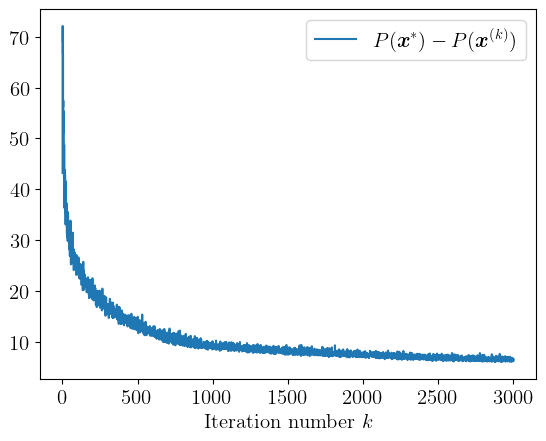

In [7]:
if __name__ == "__main__":
    from matplotlib.ticker import MultipleLocator

    fig2, ax2 = plt.subplots()

    f_i_series = {i: results[i]["f_i_series"] for i in node_names}
    err_series = sum(f_i_series.values()) - opt_val

    ax2.step(
        iterations,
        err_series,
        label=r"$P(\boldsymbol{x}^*)-P(\boldsymbol{x}^{(k)})$",
    )

    ax2.set_xlabel("Iteration number $k$")
    ax2.yaxis.set_major_locator(MultipleLocator(10))
    ax2.legend()

    plt.show()

- Constraints violation:

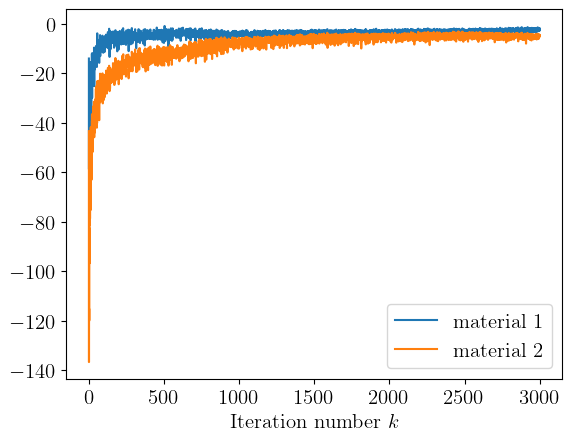

In [8]:
if __name__ == "__main__":
    fig3, ax3 = plt.subplots()
    x_series: Dict[str, NDArray[np.float64]] = {
        i: results[i]["x_i_series"] for i in node_names
    }

    constraint_values: NDArray[np.float64] = (
        sum([A_mat[i] @ x_series[i] for i in node_names]) - b_mat[:, np.newaxis]
    )

    for i in range(constraint_values.shape[0]):
        ax3.step(iterations, constraint_values[i], label=f"material {i + 1}")

    ax3.set_xlabel("Iteration number $k$")
    ax3.legend()

    plt.show()

## Save the figures:

In [9]:
if __name__ == "__main__":
    fig2.savefig(os.path.join(figure_dir, "fig_3_a.pdf"), format="pdf", bbox_inches="tight")
    fig3.savefig(os.path.join(figure_dir, "fig_3_b.pdf"), format="pdf", bbox_inches="tight")